# Машинное обучение, ВМК МГУ

## Практическое задание 4. Разложение ошибки на смещение и разброс. Градиентный бустинг ~~своими руками~~

### Общая информация

Дата выдачи: 30.11.2020 01:00

Мягкий дедлайн: 01:00MSK 14.12.2020

Жесткий дедлайн: 01:00MSK 21.12.2020

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-04-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston. 
Также в задании вам будет предложено пообучать готовые модели градиентного бустинга и CatBoost.

**Напоминание:**
    
* Все ваши графики должны быть **"красивыми"** --- подробнее о том, как их оформлять, можно найти в первом практическом задании. При несоответствии какиму-то из критериев вам могут снять баллы.
* Пишите в текстовых ячейках/print в коде ответы на **все вопросы из заданий/просьбы сделать выводы** --- при их отсутствии мы не можем понять, сделали ли вы задание и понимаете, что происходит, и поэтому будем снижать баллы

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm
import catboost
import numpy.linalg as LA 
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.datasets import load_boston
from catboost import CatBoostClassifier 
from lightgbm import LGBMClassifier

## Часть 1. Bias-Variance Decomposition

In [2]:
boston = load_boston()

Будем изучать данные о стоимости жилья в Бостоне.

In [3]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

- **data**: выборка из различных домов с признаковыми описаниями 
- **target**: целевая переменная - средняя цена на дом в 1000\$
- **feature_names**: имена признаков
- **DESCR**: описание датасета

```boston.DESCR```

Размер выборки: 506 \
Количество признаков: 13 \
Целевая переменная: **MEDV** \
Пропущенные значения: отсутсвуют
    
- **CRIM**: Per capita crime rate by town
- **ZN**: Proportion of residential land zoned for lots over 25,000 sq. ft
- **INDUS**: Proportion of non-retail business acres per town
- **CHAS**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- **NOX**: Nitric oxide concentration (parts per 10 million)
- **RM**: Average number of rooms per dwelling
- **AGE**: Proportion of owner-occupied units built prior to 1940
- **DIS**: Weighted distances to five Boston employment centers
- **RAD**: Index of accessibility to radial highways
- **TAX**: Full-value property tax rate per 10,000\$
- **PTRATIO**: Pupil-teacher ratio by town
- **B**: 1000$(B_k — 0.63)^2$, where Bk is the proportion of [people of African American descent] by town
- **LSTAT**: Percentage of lower status of the population
- **MEDV**: Median value of owner-occupied homes in 1000$

In [4]:
X = boston.data
y = boston.target

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [5]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

35.72562264449362

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__Задание 1. (1.5 баллa)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [6]:
def bootstrap_samples(X, y, num_runs, out_of_bag=False):
    """
    :param X: numpy-array выборка объектов
    :param y: numpy-array целевая переменная
    :param num_runs: int число подвыбоорок? генерируемых бутстрепом
    :param out_of_bag: bool, если True, возвращается 2D-boolean array вхождения объектоов выборки в out_of_bag
    :returns: выборка подвыборок размера n_runs вместе с соответсвующими значениями y
    """
    N = X.shape[0]
    indices = np.random.randint(0, N, (num_runs, N))
    if out_of_bag:
        out_of_bag_mask = np.ones((num_runs, N), dtype=bool)
        for i, row in enumerate(indices):
            out_of_bag_mask[i][np.unique(row)] = False
        return X[indices], y[indices], out_of_bag_mask
    else:
        return X[indices], y[indices]

def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    X_samples, y_samples, out_of_bag_mask = bootstrap_samples(X, y, num_runs, out_of_bag=True)
    y_preds = np.empty((num_runs, y.shape[0]))
    y_preds.fill(np.nan)

    for i in range(num_runs):
        X_train = X_samples[i]
        y_train = y_samples[i]
        X_test = X[out_of_bag_mask[i]]
        y_test = y[out_of_bag_mask[i]]

        regressor.fit(X_train, y_train)
        y_preds[i][out_of_bag_mask[i]] = regressor.predict(X_test)
        
    y_preds_mean = np.nanmean(y_preds, axis=0)
    y_preds_var = np.nanvar(y_preds, axis=0)
    not_nan_mask = ~np.isnan(y_preds_mean)

    y_preds_mean = y_preds_mean[not_nan_mask]
    y_preds_var = y_preds_var[not_nan_mask]
    y_new = y[not_nan_mask]
    bias = np.power(y_preds_mean - y_new, 2).mean()
    variance = y_preds_var.mean()
    loss = np.nanmean(np.power(y_preds - y, 2))
    return bias, variance, loss

**Задание 2. (0.5 баллa)**

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.


In [7]:
linear = LinearRegression()
tree = DecisionTreeRegressor(random_state=0)
forest = RandomForestRegressor(max_depth=2, random_state=0)

label = ('linear: ', 'tree: ', 'forest: ')
s = 'bias: {:.3f} + variance: {:.3f} = {:.3f} ~ loss: {:.3f}'

for i, regressor in enumerate((linear, tree, forest)):
    bias, variance, loss = compute_biase_variance(regressor, X, y, num_runs=1000)
    print(label[i] + s.format(bias, variance, bias + variance, loss))

linear: bias: 23.757 + variance: 0.940 = 24.696 ~ loss: 24.656
tree: bias: 10.133 + variance: 12.929 = 23.062 ~ loss: 23.112
forest: bias: 21.746 + variance: 2.459 = 24.204 ~ loss: 24.115


В результате, действительно, ошибка практически равна сумме разброса и смещения. Несовпадение объясняется приблизительным подсчетом интеграла, ненормальным распределением ошибки, другими погрешностями вычислений.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__Задание 3. (1.5 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

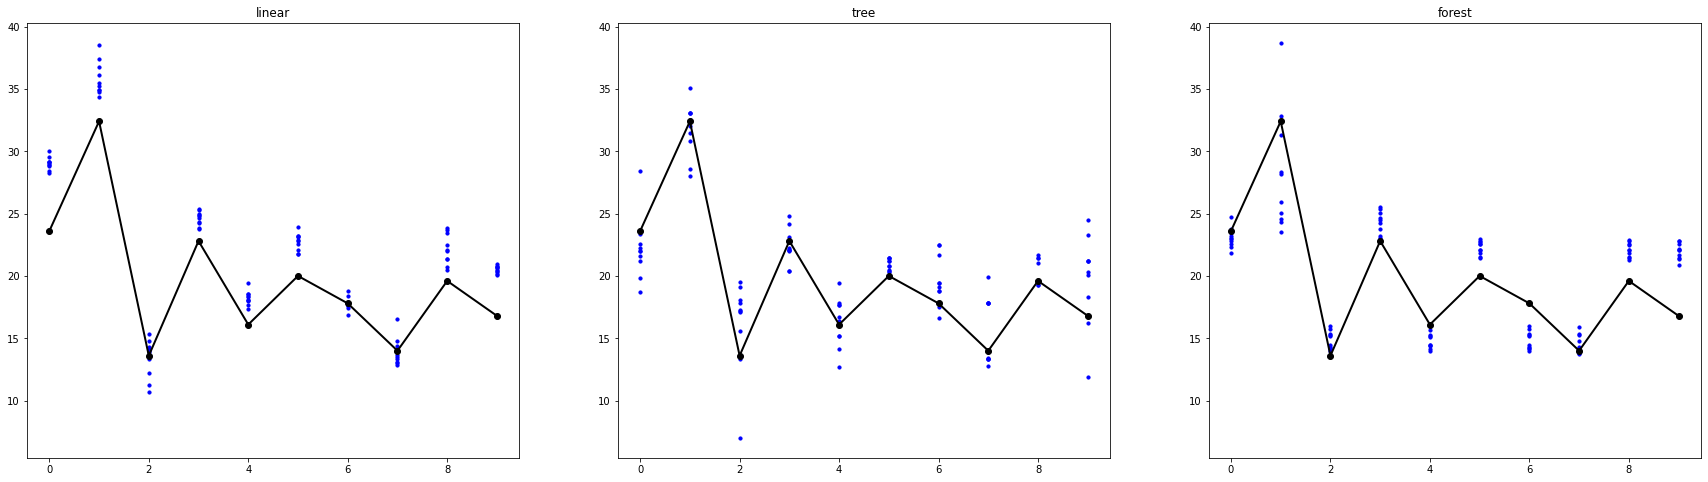

In [8]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects, random_state=42) 
    X_samples, y_samples = bootstrap_samples(X_train, y_train, num_runs, out_of_bag=False)
    plt.title(title)
    plt.plot(range(num_test_objects), y_test, 'o-', color='black', lw=2)
    for i in range(num_runs):
        regressor.fit(X_samples[i], y_samples[i])
        y_preds = regressor.predict(X_test)
        plt.scatter(range(num_test_objects), y_preds, c='b', s=10)
    
fig = plt.figure(figsize=(30, 8))

ax1 = fig.add_subplot(131)
plot_predictions(linear, X, y, num_runs=10, num_test_objects=10, title="linear")

ax2 = fig.add_subplot(132, sharey=ax1)
plot_predictions(tree, X, y, num_runs=10, num_test_objects=10, title="tree")

ax3 = fig.add_subplot(133, sharey=ax1)
plot_predictions(forest, X, y, num_runs=10, num_test_objects=10, title="forest")


Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

### Часть 2. Градиентный бустинг

**Задание 4 (1 балл)**

Мы будем использовать датасет группы "Home Credit" по предоставлению кредитов. 
* Загрузить таблицу application_train.csv;
* Записать в y столбец с целевой переменной (TARGET);

In [9]:
df = pd.read_csv('/home/youngcat/Downloads/application_train.csv')
y = df['TARGET']
X = df.drop(columns=['TARGET'])

* Удалить ненужные столбцы:\
Проанализировав описания признаков в таблице 'Home_Credit_description.csv', исключим относительно бесполезные признаки с APARTMENTS_AVG по EMERGENCYSTATE_MODE, флаги документов FLAG_DOCUMENT_N, с AMT_REQ_CREDIT_BUREAU_HOUR по AMT_REQ_CREDIT_BUREAU_YEAR. В статье https://habr.com/ru/post/414613/ изучены некооторые другие признаки. А именно: 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START' отмечены как не слишком влияющие на решение о выдаче кредита. Потому от них тоже избавляемся. Другие флаговые признаки суммируем в один столбец из предположения, что чем больше из них отмечено "1", тем лучше. 
После этого избавимся от признаков, в которых слишком много пропусков. 

In [10]:
X = X.drop(columns=X.columns[X.columns.get_loc('APARTMENTS_AVG') : 
                             X.columns.get_loc('EMERGENCYSTATE_MODE') + 1])
X = X.drop(columns=X.columns[X.columns.get_loc('FLAG_DOCUMENT_2') : 
                             X.columns.get_loc('FLAG_DOCUMENT_21') + 1])
X = X.drop(columns=X.columns[X.columns.get_loc('AMT_REQ_CREDIT_BUREAU_HOUR') : 
                             X.columns.get_loc('AMT_REQ_CREDIT_BUREAU_YEAR')])
X = X.drop(columns=['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'])

flag = X.columns[X.columns.get_loc('FLAG_MOBIL') : 
                 X.columns.get_loc('FLAG_EMAIL') + 1]
X['CONTACT_FLAG'] = X[flag].sum(axis=1)
X = X.drop(columns=flag)

flag = X.columns[X.columns.get_loc('REGION_RATING_CLIENT_W_CITY') : 
                 X.columns.get_loc('LIVE_CITY_NOT_WORK_CITY') + 1]
X['ADRESS_FLAG'] = X[flag].sum(axis=1)
X = X.drop(columns=flag)

X = X.drop(columns=X.columns[X.isna().sum() >= 0.1 * len(X)])

Взглянем на корреляцию признаков в результате

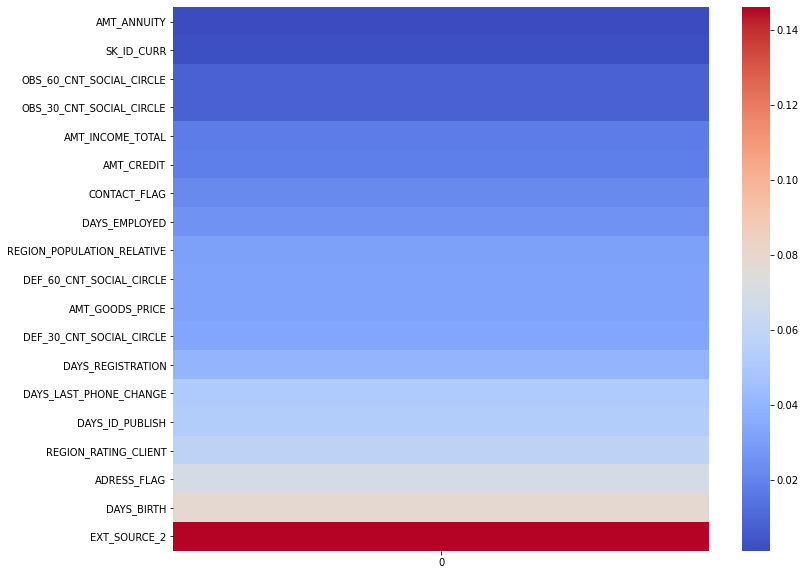

In [11]:
plt.figure(figsize=(12,10))
abs_cor = abs(X.corrwith(y, method='spearman')).sort_values()
sns.heatmap(pd.DataFrame(abs_cor), cmap='coolwarm')
plt.show()

Ну, все лучше, чем абсолютно синее полотно изначальных 122 признаков.

* Определить тип столбцов и заполнить пропуски - стратегия произвольная;

In [12]:
X.dtypes

SK_ID_CURR                      int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH                 int64
REGION_RATING_CLIENT            int64
ORGANIZATION_TYPE              object
EXT_SOURCE_2                  float64
OBS_30_CNT_SOCIAL_CIRCLE      float64
DEF_30_CNT_SOCIAL_CIRCLE      float64
OBS_60_CNT_SOCIAL_CIRCLE      float64
DEF_60_CNT_SOCIAL_CIRCLE      float64
DAYS_LAST_PH

Запомним категориальные признаки:

In [13]:
cat_mask = X.dtypes==object
cat_indices = np.where(cat_mask)[0]
cat_feature = X.columns[cat_mask]
num_feature = X.columns[~cat_mask]

Заполним столбцы с пропусками самым частым значением по столбцу

In [14]:
si = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
columns = X.columns[X.isna().sum() > 0]
X[columns] = si.fit_transform(X[columns])

* Разбить выборку в соотношении 70:30 с random_state=0.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**Задание 5 (1 балл)**

Обучить реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

Одобрено: 91.911%, Не одобрено: 8.089%


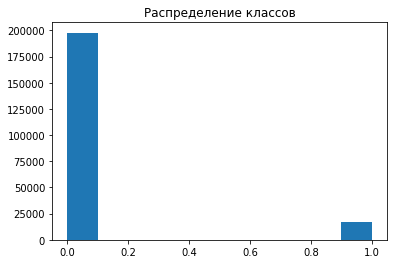

In [16]:
balance = y.value_counts(normalize=True).values * 100
print('Одобрено: {:.3f}%, Не одобрено: {:.3f}%'.format(balance[0], balance[1]))
plt.hist(y)
plt.title('Распределение классов')
plt.show()

### CatBoost

In [17]:
%%time

cat = CatBoostClassifier(iterations=300, logging_level='Silent')
cat.fit(X_train[num_feature], y_train)

print(roc_auc_score(y_test, cat.predict_proba(X_test[num_feature])[:, 1]))

0.700296860409721
CPU times: user 1min 12s, sys: 1.58 s, total: 1min 13s
Wall time: 4.99 s


### LightGBM

In [18]:
%%time

lgbm = LGBMClassifier(n_estimators=300)
lgbm.fit(X_train[num_feature], y_train)

print(roc_auc_score(y_test, lgbm.predict_proba(X_test[num_feature])[:, 1]))

0.7004937001611482
CPU times: user 17.2 s, sys: 41.2 ms, total: 17.3 s
Wall time: 1.16 s


Итак, можно заметить, что разница в качестве, мягко говоря, невелика, а вот во времени значительна, что подтверждает теорию о том, что catboost работает хорошо только при правильно настроенных категориальных данных.

__Задание 6. (2 балла)__

Подобрать оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев
* количество деревьев
* темп обучения
* оптимизируемый функционал

In [19]:
def fit_score(clf):
    clf.fit(X_train[num_feature], y_train)
    train_score = roc_auc_score(y_train, clf.predict_proba(X_train[num_feature])[:, 1])
    test_score = roc_auc_score(y_test, clf.predict_proba(X_test[num_feature])[:, 1])
    return train_score, test_score

def plot(x, xlabel):
    plt.figure(figsize=(8, 5))
    for i, label in enumerate(('cat_train', 'cat_test', 'lgbm_train', 'lgbm_test')):
        plt.plot(x, roc_auc[:,i], marker='.', label=label)
    plt.xlabel(xlabel)
    plt.ylabel('AUC-ROC')
    plt.legend()
    plt.show()

Оценим **глубину**. Остальные параметры оставляем по умолчанию.

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


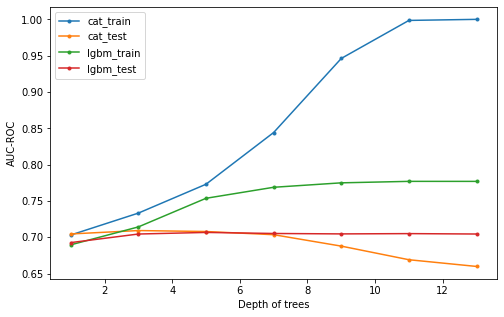

CPU times: user 1h 45s, sys: 1min 46s, total: 1h 2min 31s
Wall time: 6min 53s


In [20]:
%%time
depth = list(range(1, 15, 2))
roc_auc = np.empty((len(depth), 4))

for i, d in enumerate(depth):
    cat = CatBoostClassifier(max_depth=d, logging_level="Silent")
    lgbm = LGBMClassifier(max_depth=d)
    roc_auc[i] = fit_score(cat) + fit_score(lgbm)
plot(depth, 'Depth of trees')

Как видно, оптимальная глубина для catboost: **5** lightgbm: **5**

Оценим **число деревьев**. Остальные параметры оставляем по умолчанию.

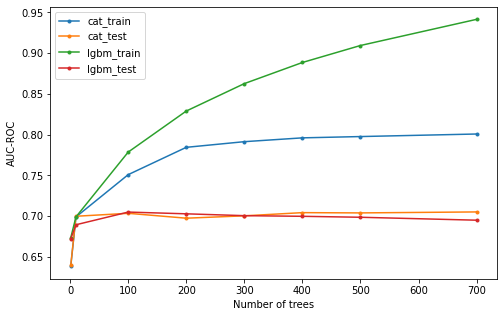

CPU times: user 10min 53s, sys: 12.9 s, total: 11min 6s
Wall time: 45.8 s


In [21]:
%%time
n_trees = [1, 10, 100, 200, 300, 400, 500, 700]
roc_auc = np.empty((len(n_trees), 4))

for i, n in enumerate(n_trees):
    cat = CatBoostClassifier(n_estimators=n, logging_level="Silent")
    lgbm = LGBMClassifier(n_estimators=n)
    roc_auc[i] = fit_score(cat) + fit_score(lgbm)
plot(n_trees, 'Number of trees')

Как видно, оптимальное число деревьев для catboost: **100** lightgbm: **100**

Оценим **темп обучения**. Остальные параметры оставляем по умолчанию.

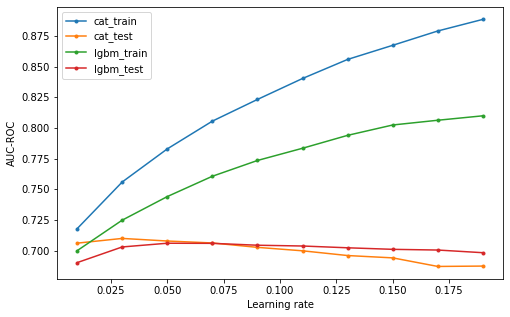

CPU times: user 40min 46s, sys: 54.8 s, total: 41min 41s
Wall time: 2min 44s


In [22]:
%%time
learning_rate = list(np.arange(0.01, 0.2, 0.02))
roc_auc = np.empty((len(learning_rate), 4))

for i, lr in enumerate(learning_rate):
    cat = CatBoostClassifier(learning_rate=lr, logging_level="Silent")
    lgbm = LGBMClassifier(learning_rate=lr)
    roc_auc[i] = fit_score(cat) + fit_score(lgbm)
plot(learning_rate, 'Learning rate')

Как видно, оптимальный темп для catboost: **0.075** lightgbm: **0.075**

Оценим **минимизируемый функционал**. Остальные параметры оставляем по умолчанию.

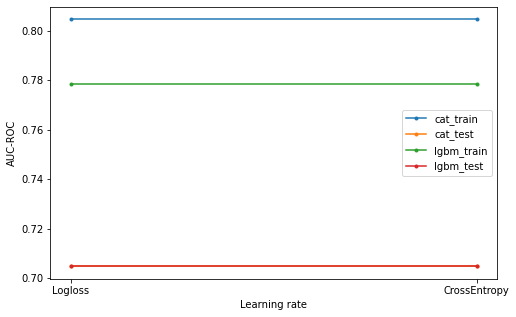

CPU times: user 8min 9s, sys: 10.6 s, total: 8min 20s
Wall time: 32.7 s


In [23]:
%%time
metrics = ('Logloss', 'CrossEntropy')
roc_auc = np.empty((len(metrics), 4))

for i, m in enumerate(metrics):
    cat = CatBoostClassifier(loss_function=m, logging_level="Silent")
    lgbm = LGBMClassifier(metric=m)
    roc_auc[i] = fit_score(cat) + fit_score(lgbm)
plot(metrics, 'Learning rate')

**Задание 7 (1.5 баллa)**

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

Можно использовать библиотечные реализации; при подсчете счетчиков нельзя использовать циклы.

Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования? (Параметры можно не подбирать).

In [24]:
X_copy = X.copy()

In [25]:
def smooth_counter(X, y, cat_feature):
    X['target'] = y
    C = 10
    prior = y.mean()
    X_code = X[cat_feature].copy()
    for cf in cat_feature:
        X[cf] = X[cf].map((X.groupby(cf)['target'].sum() + C * prior) / (X[cf].value_counts() + C))
    X = X.drop(columns=['target'])
    return X

X_sc = smooth_counter(X, y, cat_feature)

In [26]:
X = X_copy
X_gd = pd.get_dummies(X, columns=cat_feature)

In [27]:
from time import time

def time_stat(X, title):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    start = time()
    cat = CatBoostClassifier(logging_level='Silent')
    cat.fit(X_train[num_feature], y_train)
    cat_time = time() - start

    start = time()
    lgbm = LGBMClassifier()
    lgbm.fit(X_train[num_feature], y_train)
    lgbm_time = time() - start

    print(title + 'cat_time: {:.3f}sec, lgbm_time: {:.3f}sec'.format(cat_time, lgbm_time))

In [28]:
time_stat(X_gd, 'One-hot time: ')
time_stat(X_sc, 'Smooth_counter time: ')

One-hot time: cat_time: 15.701sec, lgbm_time: 0.425sec
Smooth_counter time: cat_time: 15.814sec, lgbm_time: 0.477sec


**Задание 8 (1 балл)**

Для CatBoost можно не делать ручную обработку категориальных признаков, а подавать как есть. Обучите модель CatBoost, не обрабатывая специально категориальные признаки, замерьте время обучения (параметры возьмите из предыдущего пункта).  Сравните с временем обучения модели CatBoost из предыдущего пункта. Как изменилось время? Почему?

In [29]:
X = X_copy

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

start = time()
cat = CatBoostClassifier(cat_features=cat_indices, logging_level='Silent')
cat.fit(X_train, y_train)
cat_time = time() - start

In [31]:
cat_time

43.31150770187378

**Бонус. (1 балл)**

Подберите оптимальные параметры для LightGBM с вещественными и категориальными признаками (предварительно обработанные каким-нибудь способом). Подберите оптимальные параметры для CatBoost с вещественными и необработанными категориальными признаками. Сравните качество моделей на наилучших параметрах. Какой метод получился лучше с точки зрения качества? Совпадает ли результат с вашими ожиданиями?

**Бонус (0.2 балла)**
![](https://sun9-9.userapi.com/impg/SPQtmsIMbfJYL65dpu1CajqF6AzUn49FHkeA5w/eEmP2FxDRsU.jpg?size=1060x1080&quality=96&proxy=1&sign=56b757698386e81337979247af59da18&type=album)